In [11]:
import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation

In [12]:
import numpy as np
#import h5py
import os
import matplotlib.pyplot as plt
from IPython.display import HTML, display

os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [13]:
#定义函数
def make_video_from_solution(
    solution,
    quantities=("order_parameter", "phase"),
    fps=20,
    figsize=(5, 4),
):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            video = anim.to_html5_video()
        return HTML(video)

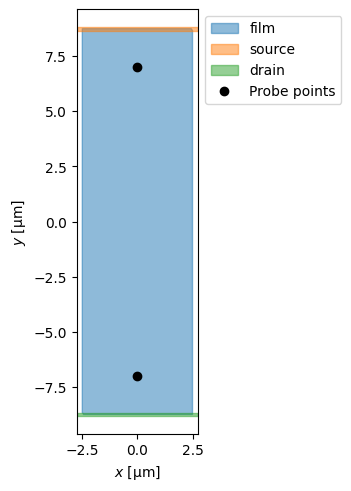

In [14]:
#定义形状和参数
length_units = "um"

# Material parameters
xi = 0.5 #相干长度
london_lambda = 2 #伦敦穿透
d = 0.1 #厚度
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=1)

# Device geometry
total_width = 5
total_length = 3.5 * total_width
link_width = total_width / 3 #这是什么

# Outer geometry of the film
film = (
    tdgl.Polygon("film", points=box(total_width, total_length))
    .resample(401)
    .buffer(0)
)

# Current terminals
source = (
    tdgl.Polygon("source", points=box(1.1 * total_width, total_length / 100))
    .translate(dy=total_length / 2)
)
drain = source.scale(yfact=-1).set_name("drain")

#  Voltage measurement points
probe_points = [(0, total_length / 2.5), (0, -total_length / 2.5)]

device = tdgl.Device(
    "weak_link",
    layer=layer,
    film=film,
    terminals=[source, drain],
    probe_points=probe_points,
    length_units=length_units,
)

fig, ax = device.draw()

Constructing Voronoi polygons: 100%|██████████| 4931/4931 [00:01<00:00, 2716.91it/s]


num_sites,4931
num_elements,9460
min_edge_length,7.006e-02
max_edge_length,2.379e-01
mean_edge_length,1.459e-01
min_area,2.901e-03
max_area,3.585e-02
mean_area,1.774e-02
coherence_length,5.000e-01
length_units,um


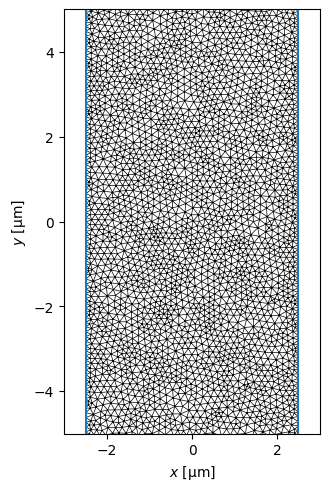

In [15]:
#有限元构造
device.make_mesh(max_edge_length=xi / 2, smooth=100)
fig, ax = device.plot(mesh=True, legend=False)
_ = ax.set_ylim(-5, 5)
device.mesh_stats()

In [16]:
#设置外场的时间依赖
from tdgl import Parameter
from tdgl.em import uniform_Bz_vector_potential, ureg

def scaling(t, tmin=0, t_up=40, t_down=60, tmax=80, initial=0.0, middle=2.0, final=1.0):
    if t < tmin:
        return initial
    elif tmin <= t < t_up:
        return initial + (middle - initial) * (t - tmin) / (t_up - tmin)
    elif t_up <= t < t_down:
        return middle
    elif t_down <= t < tmax:
        return middle + (final - middle) * (t - t_down) / (tmax - t_down)
    return final

def field_vector_potential(x, y, z, *, t, time_factor, Bz: float, field_units: str = "mT", length_units: str = "um"):
    if z.ndim == 0:
        z = z * np.ones_like(x)
    positions = np.array([x.squeeze(), y.squeeze(), z.squeeze()]).T
    positions = (positions * ureg(length_units)).to("m").magnitude
    Bz = Bz * ureg(field_units) * time_factor(t=t)
    A = uniform_Bz_vector_potential(positions, Bz)
    return A.to(f"{field_units} * {length_units}").magnitude

def VaryingField(
    value: float = 0, time_factor=lambda t: 1.0, field_units: str = "mT", length_units: str = "um"
) -> Parameter:
    """Returns a Parameter that computes a constant as a function of ``x, y, z``.
    Args:
        value: The constant value of the field.
    Returns:
        A Parameter that returns ``value`` at all ``x, y, z``.
    """
    return Parameter(
        field_vector_potential,
        Bz=float(value),
        time_factor=time_factor,
        field_units=field_units,
        length_units=length_units,
        time_dependent=True
    )

def plot_externel_field(func=lambda t: 1.0, time_range=np.linspace(0, 100, 100)):
    t = time_range
    B = np.zeros_like(t)
    for i in range(len(t)):
        dt = t[i]
        B[i] = func(dt)
    plt.plot(t, B)

plot_externel_field(scaling, np.linspace(0, 100, 100))

In [19]:
#设置求解参数和外场并求解
options = tdgl.SolverOptions(
    # Allow some time to equilibrate before saving data.
    skip_time=100, #先热化后模拟
    solve_time=100,
    output_file=os.path.join('solutions', "weak-link-zero-field.h5"),
    field_units = "mT",
    current_units="uA",
    save_every=100,
)

# varying uniform field according to time_factor
applied_vector_potential = (
    VaryingField(0.4, time_factor=scaling, field_units=options.field_units, length_units=device.length_units)
)

zero_current_solution = tdgl.solve(
    device,
    options,
    applied_vector_potential=applied_vector_potential,
)

Output file already exists. Renaming to solutions\weak-link-zero-field-2.h5.
Simulating: 100%|█████████▉| 100/100 [01:12<00:00,  1.38tau/s ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "d:\Anaconda3\envs\tdgl\lib\site-packages\tdgl\solution\solution.py", line 882, in serialize_func
    h5group.attrs[name] = func
  File "h5py\\_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py\\_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "d:\Anaconda3\envs\tdgl\lib\site-packages\h5py\_hl\attrs.py", line 104, in __setitem__
    self.create(name, data=value)
  File "d:\Anaconda3\envs\tdgl\lib\site-packages\h5py\_hl\attrs.py", line 182, in create
    htype = h5t.py_create(original_dtype, logical=True)
  File "h5py\\h5t.pyx", line 1663, in h5py.h5t.py_create
  File "h5py\\h5t.pyx", line 1687, in h5py.h5t.py_create
  File "h5py\\h5t.pyx", line 1747, in h5py.h5t.py_create
TypeError: Object dtype dtype('O') has

TypeError: cannot pickle 'weakref.ReferenceType' object

In [10]:
fig, axes = zero_current_solution.plot_order_parameter(figsize=(5.5, 4))

NameError: name 'zero_current_solution' is not defined

In [50]:
(LinearRamp(tmin=0, tmax=50, initial=0, final=1)
* ConstantField(0.4, field_units=options.field_units, length_units=device.length_units),
LinearRamp(tmin=50, tmax=100, initial=1, final=0)
* ConstantField(0, field_units=options.field_units, length_units=device.length_units))

(CompositeParameter<(linear_ramp(time_dependent=True, initial=0, final=1, tmin=0, tmax=50) * constant_field_vector_potential(field_units='mT', length_units='um', Bz=0.4))>,
 CompositeParameter<(linear_ramp(time_dependent=True, initial=1, final=0, tmin=50, tmax=100) * constant_field_vector_potential(field_units='mT', length_units='um', Bz=0.0))>)

In [46]:
LinearRamp(tmin=0, tmax=50, initial=0, final=1)

Parameter<linear_ramp(time_dependent=True, initial=0, final=1, tmin=0, tmax=50)>